# Regression on Sydney Dataset 
### 0. Libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import RobustScaler
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso,Ridge,ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
data = pd.read_csv('data/data.csv')

In [3]:
data.head(5)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


### 1. Determine which features are continuous vs categorical. Drop rows without a valid salesprice.

In [4]:
categorical = ['bedrooms','bathrooms','floors','waterfront','view','condition','street','city',
               'statezip','country']

In [5]:
continuous = [i for i in data.columns if i not in categorical + ['date','price']]

In [6]:
print(continuous)

['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']


In [7]:
data = data.drop(index = data[data.price == 0].index)

### 2. Visualize the univariate distribution of each continuous feature, and the distribution of thetarget. Do you notice anything? Is there something that might require special treatment?

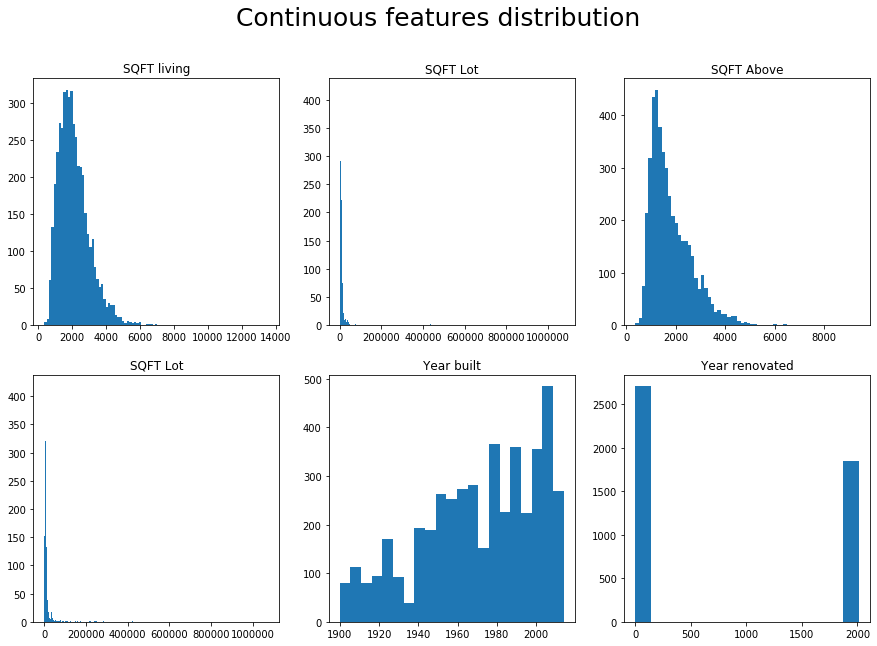

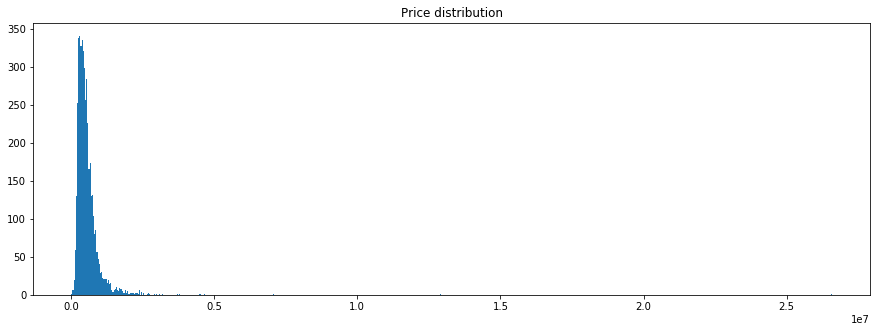

In [8]:
f, ax = plt.subplots(nrows=2,ncols=3,figsize=(15,10))

plt.suptitle('Continuous features distribution', fontsize=25)

ax[0,0].hist(data['sqft_living'],bins='auto')
ax[0,0].set_title('SQFT living')

ax[0,1].hist(data['sqft_lot'],bins='auto')
ax[0,1].set_title('SQFT Lot')

ax[0,2].hist(data['sqft_above'],bins='auto')
ax[0,2].set_title('SQFT Above')

ax[1,0].hist(data['sqft_lot'],bins='auto')
ax[1,0].set_title('SQFT Lot')

ax[1,1].hist(data['yr_built'],bins='auto')
ax[1,1].set_title('Year built')

ax[1,2].hist(data['yr_renovated'],bins='auto')
ax[1,2].set_title('Year renovated')

plt.show()

plt.figure(figsize=(15,5))
plt.hist(data.price,bins='auto')
plt.title('Price distribution')
plt.show()

### 3. Visualize the dependency of the target on each continuous feature (2d scatter plot).

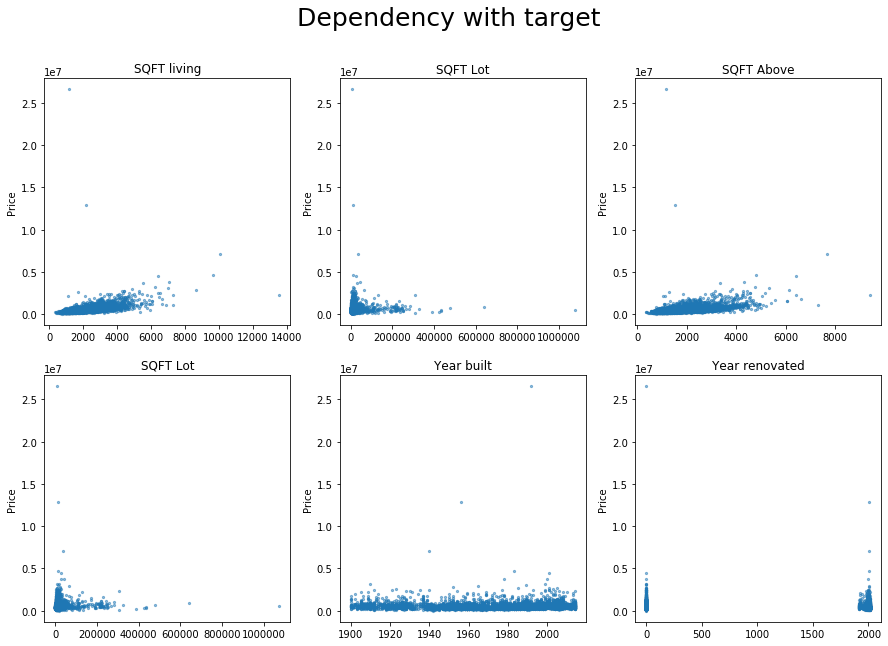

In [9]:
f, ax = plt.subplots(nrows=2,ncols=3,figsize=(15,10))

plt.suptitle('Dependency with target', fontsize=25)

ax[0,0].scatter(data['sqft_living'],data['price'],s=5,alpha=0.5)
ax[0,0].set_title('SQFT living')
ax[0,0].set_ylabel('Price')

ax[0,1].scatter(data['sqft_lot'],data['price'],s=5,alpha=0.5)
ax[0,1].set_title('SQFT Lot')
ax[0,1].set_ylabel('Price')

ax[0,2].scatter(data['sqft_above'],data['price'],s=5,alpha=0.5)
ax[0,2].set_title('SQFT Above')
ax[0,2].set_ylabel('Price')

ax[1,0].scatter(data['sqft_lot'],data['price'],s=5,alpha=0.5)
ax[1,0].set_title('SQFT Lot')
ax[1,0].set_ylabel('Price')

ax[1,1].scatter(data['yr_built'],data['price'],s=5,alpha=0.5)
ax[1,1].set_title('Year built')
ax[1,1].set_ylabel('Price')

ax[1,2].scatter(data['yr_renovated'],data['price'],s=5,alpha=0.5)
ax[1,2].set_title('Year renovated')
ax[1,2].set_ylabel('Price')

plt.show()

### 4. Split data in training and test set. Do not use the test-set unless for a final evaluation in 2.5.Use ColumnTransformer and pipeline to encode categorical variables (your choice ofOneHotEncoder or another one from the categorical_encoder package, or both). Impute missingvalues using SimpleImputer. Evaluate Linear Regression (OLS), Ridge, Lasso and ElasticNetusing cross-validation with the default parameters. Does scaling the data (within the pipeline)with StandardScaler help? Use the preprocessing that works best going forward.

In [10]:
X_train,X_test,y_train,y_test = train_test_split(data.drop(['price','date'],axis=1),
                                                 data['price'],
                                                 test_size=0.2)

target_encoding = []
onehot = []

for cat in categorical:
    if len(X_train[cat].unique()) >= 10:
        target_encoding.append(cat)
    else:
        onehot.append(cat)

In [11]:
target_encoding

['bedrooms', 'bathrooms', 'street', 'city', 'statezip']

In [12]:
onehot

['floors', 'waterfront', 'view', 'condition', 'country']

In [13]:
numeric_transformer = Pipeline(steps=[('scaler', RobustScaler())])

categorical_transformer = Pipeline(steps=[('target_encoding',ce.TargetEncoder(cols=target_encoding,return_df=True)),
                                          ('onehot_encoding',ce.one_hot.OneHotEncoder(cols=onehot,return_df=True))])

preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, categorical),
                                               ('num', numeric_transformer, continuous)])

pipe_ols = Pipeline([('Preprocess',preprocessor),
                     ('Regressor',LinearRegression())])

pipe_ridge = Pipeline([('Preprocess',preprocessor),
                       ('Regressor',Ridge(max_iter=100000))])

pipe_lasso = Pipeline([('Preprocess',preprocessor),
                     ('Regressor',Lasso(max_iter=100000))])

pipe_en = Pipeline([('Preprocess',preprocessor),
                    ('Regressor',ElasticNet(max_iter=100000))])

cv_ols = cross_val_score(pipe_ols,X_train,y_train)
cv_ridge = cross_val_score(pipe_ridge,X_train,y_train)
cv_lasso = cross_val_score(pipe_lasso,X_train,y_train)
cv_en = cross_val_score(pipe_en,X_train,y_train)

print('Scores with SCALER')
print('CV score - OLS:',cv_ols.mean())
print('CV score - Ridge:',cv_ridge.mean())
print('CV score - Lasso:',cv_lasso.mean())
print('CV score - ElasticNet:',cv_en.mean())

Scores with SCALER
CV score - OLS: 0.4727119058997135
CV score - Ridge: 0.472823156441454
CV score - Lasso: 0.47271407850170866
CV score - ElasticNet: 0.4193109322267145


In [14]:
categorical_transformer = Pipeline(steps=[('target_encoding',ce.TargetEncoder(cols=target_encoding,return_df=True)),
                                          ('onehot_encoding',ce.one_hot.OneHotEncoder(cols=onehot,return_df=True))])

preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, categorical)])

pipe_ols = Pipeline([('Preprocess',preprocessor),
                     ('Regressor',LinearRegression())])

pipe_ridge = Pipeline([('Preprocess',preprocessor),
                       ('Regressor',Ridge(max_iter=10000))])

pipe_lasso = Pipeline([('Preprocess',preprocessor),
                     ('Regressor',Lasso(max_iter=10000))])

pipe_en = Pipeline([('Preprocess',preprocessor),
                    ('Regressor',ElasticNet(max_iter=10000))])

cv_ols = cross_val_score(pipe_ols,X_train,y_train)
cv_ridge = cross_val_score(pipe_ridge,X_train,y_train)
cv_lasso = cross_val_score(pipe_lasso,X_train,y_train)
cv_en = cross_val_score(pipe_en,X_train,y_train)

print('Scores without SCALER')
print('CV score - OLS:',cv_ols.mean())
print('CV score - Ridge:',cv_ridge.mean())
print('CV score - Lasso:',cv_lasso.mean())
print('CV score - ElasticNet:',cv_en.mean())

Scores without SCALER
CV score - OLS: 0.3946574526950369
CV score - Ridge: 0.39467477185052663
CV score - Lasso: 0.39465802701813324
CV score - ElasticNet: 0.35722751768374505


### 5. Tune the parameters of the models using GridSearchCV. Do the results improve? Visualizethe dependence of the validation score on the parameters for Ridge, Lasso and ElasticNet.

In [19]:
numeric_transformer = Pipeline(steps=[('scaler', RobustScaler())])

categorical_transformer = Pipeline(steps=[('target_encoding',ce.TargetEncoder(cols=target_encoding,return_df=True)),
                                          ('onehot_encoding',ce.one_hot.OneHotEncoder(cols=onehot,return_df=True))])

preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, categorical),
                                               ('num', numeric_transformer, continuous)])

pipe_ols = Pipeline([('Preprocess',preprocessor),
                     ('Regressor',LinearRegression())])

pipe_ridge = Pipeline([('Preprocess',preprocessor),
                       ('Regressor',Ridge(max_iter=100000))])

pipe_lasso = Pipeline([('Preprocess',preprocessor),
                     ('Regressor',Lasso(max_iter=100000))])

pipe_en = Pipeline([('Preprocess',preprocessor),
                    ('Regressor',ElasticNet(max_iter=100000))])

params_ols = {'Regressor__fit_intercept':[True,False]}
params_ridge = {'Regressor__alpha':[0.5,1,1.5,2,3,5,7,10,20]}
params_lasso = {'Regressor__alpha':[0.5,1,1.5,2,3,5,7,10,20]}
params_en = {'Regressor__l1_ratio':[0.1,0.25,0.5,0.75,0.9],
             'Regressor__alpha':[0.5,1,1.5,2,3,5,7,10,20]}


search_ols = GridSearchCV(pipe_ols,params_ols)
search_ridge = GridSearchCV(pipe_ridge,params_ridge)
search_lasso = GridSearchCV(pipe_lasso,params_lasso)
search_en = GridSearchCV(pipe_en,params_en)

search_ols.fit(X_train,y_train)
search_ridge.fit(X_train,y_train)
search_lasso.fit(X_train,y_train)
search_en.fit(X_train,y_train)

print('OLS score:',search_ols.best_score_,'\nParams:',search_ols.best_params_)
print('Ridge score:',search_ridge.best_score_,'\nParams:',search_ridge.best_params_)
print('Lasso score:',search_lasso.best_score_,'\nParams:',search_lasso.best_params_)
print('ElasticNet score:',search_en.best_score_,'\nParams:',search_en.best_params_)

/home/leo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94679361891051.38, tolerance: 117245008572.57591
  positive)
/home/leo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76615334083977.56, tolerance: 104732471824.89484
  positive)
/home/leo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96282360507889.12, tolerance: 119610729712.60493
  positive)
/home/leo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number o

OLS score: 0.47271190590001816 
Params: {'Regressor__fit_intercept': False}
Ridge score: 0.4729366719792957 
Params: {'Regressor__alpha': 5}
Lasso score: 0.4727476100454163 
Params: {'Regressor__alpha': 20}
ElasticNet score: 0.4641711766939995 
Params: {'Regressor__alpha': 0.5, 'Regressor__l1_ratio': 0.9}


### 6. Visualize the 20 most important coefficients of the resulting models. Do they agree on whichfeatures are important?